## Get data and packages

In [2]:
import os

os.chdir(os.path.join(os.getcwd(), '..'))
import src.preprocessing
import src.model_training

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time
import shap
import lightgbm as lgb

import json
import sys

from verstack import LGBMTuner
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = src.preprocessing.get_train_data('data/data_pricing_challenge.csv')

Model Training

In [4]:
target = 'price'
variables = src.model_training.txt_load('utils/model_variables.txt')
hyperparameters = src.model_training.json_load('utils/model_hyperparameters.json')

X = df.loc[:, variables]
y = df.loc[:, [target]]


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 5629.502413843573
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 5705.5596282211445
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 5585.729744769907
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 5094.049291974347
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 3368.070000828856
 ..................................................

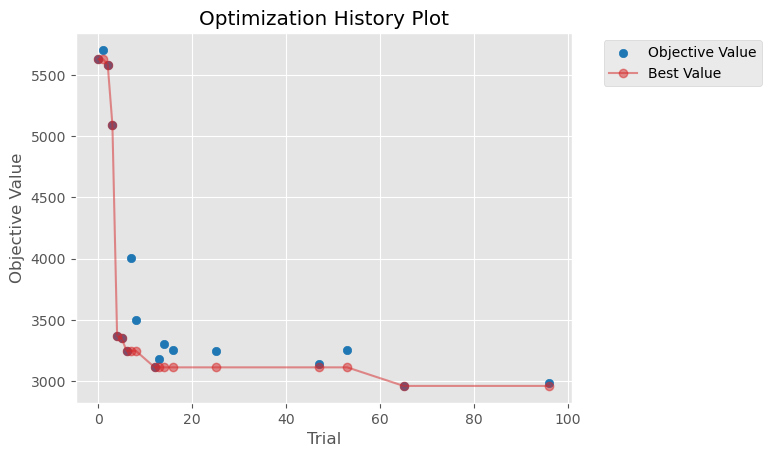

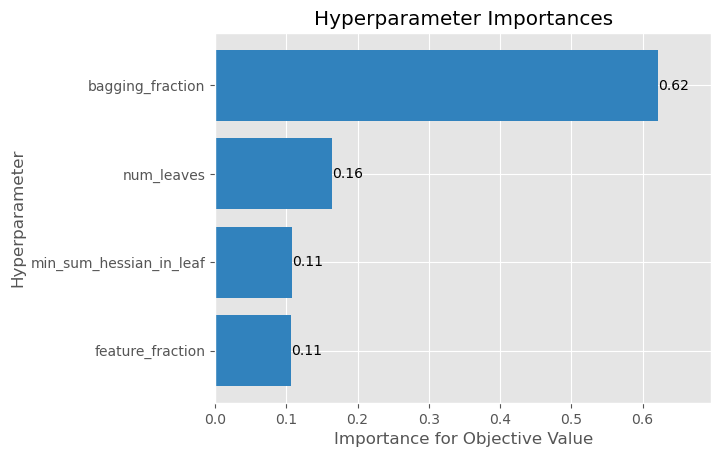

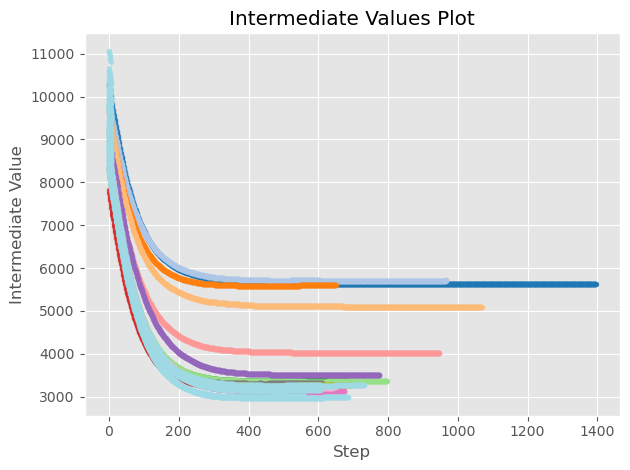

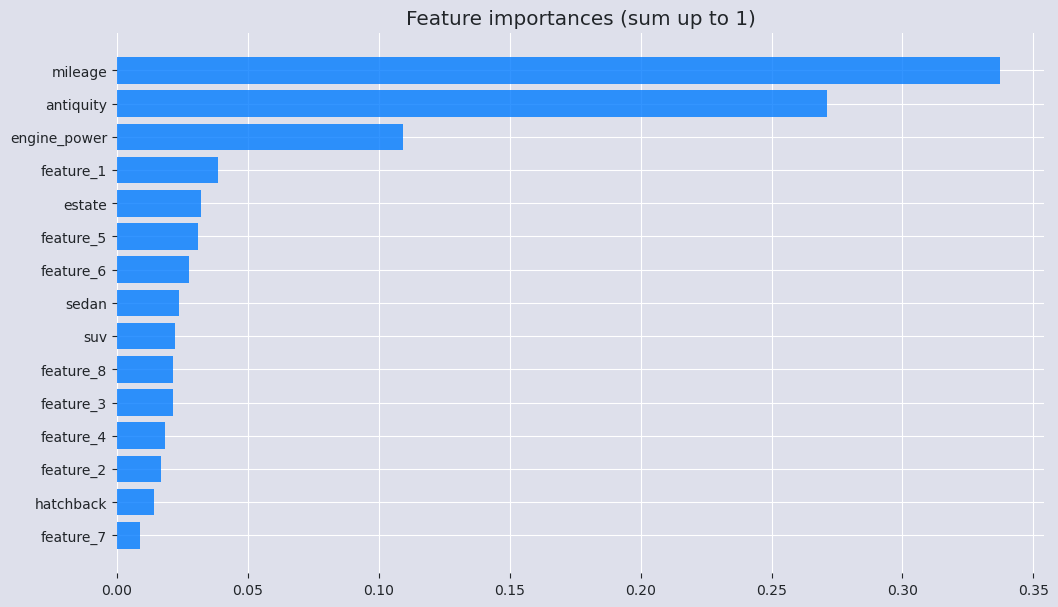


     . Optuna hyperparameters optimization finished
     .. Best trial number:65    |     rmse:            2960.372087010729
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 1 min 14.319 sec


In [7]:
# Initial tune to optimize hyperparameters
tuner = LGBMTuner(metric = 'rmse', random_state = 123)
tuner.fit(X, y['price'])

In [12]:
X_train, X_test, y_train, y_test = src.model_training.split_dataset(df, variables, target, 0.4)

model = src.model_training.lightgbm_training(X_train, y_train, hyperparameters)

Plots and Model Performance Analysis

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

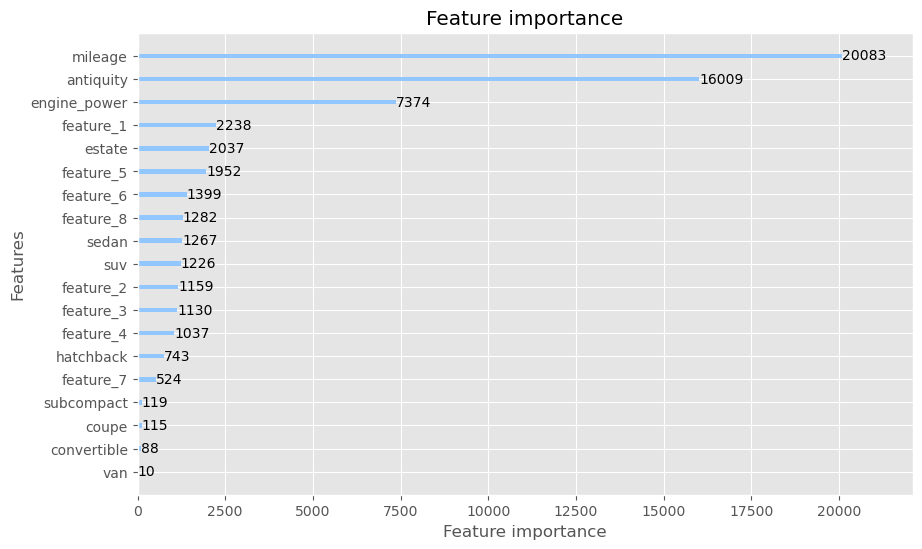

In [13]:
lgb.plot_importance(model, max_num_features=30, figsize=(10, 6))

In [14]:
src.model_training.model_results(model, X_train, X_test, y_train, y_test)

Model Results:

RMSE train: 3358.2410826484966
RMSE test: 4278.71711672752

MAE train: 1442.156618523476
MAE test: 2200.9712721706655

R2 train: 0.8642132044788062
R2 test: 0.7916247600631743


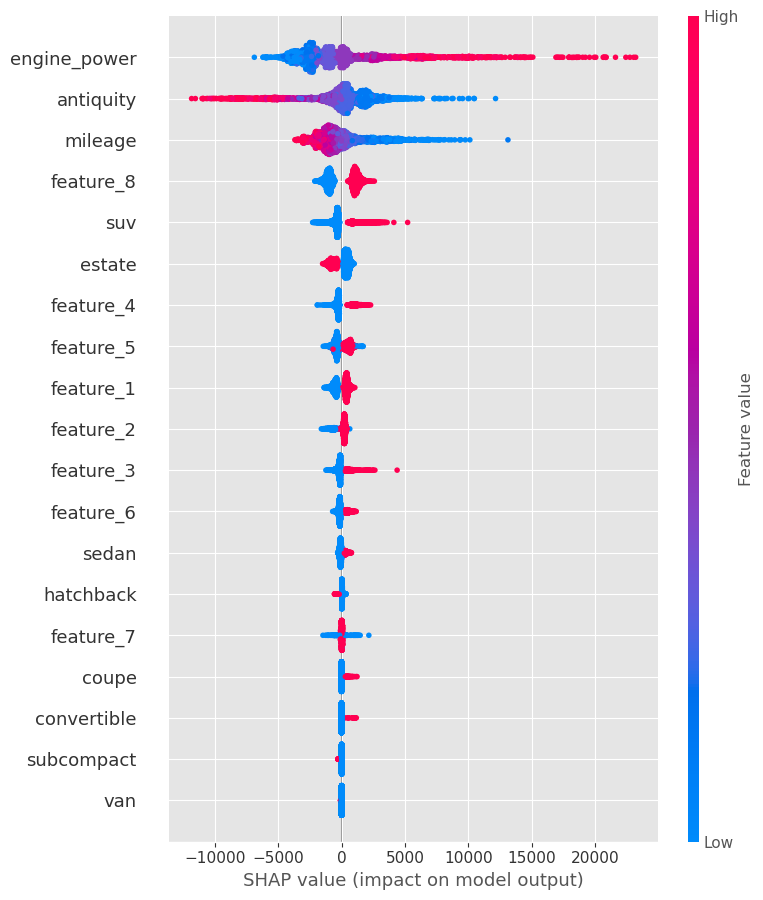

In [16]:
explainer, shap_values = src.model_training.calculate_shap_values(model, X_train)

# Visualize Shapley values
shap.summary_plot(shap_values, X_train)

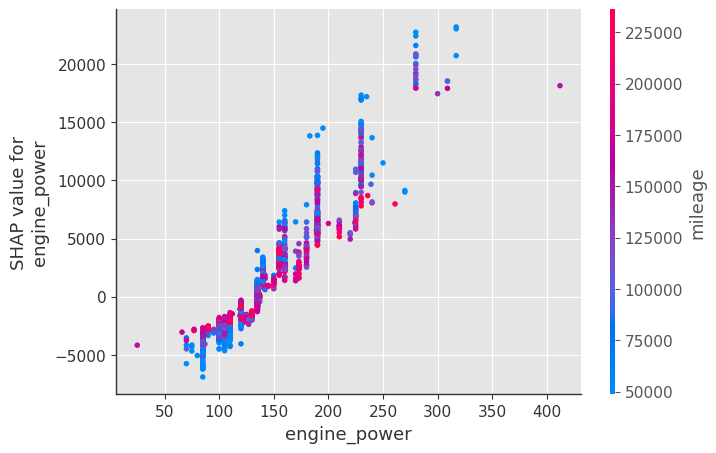

In [17]:
shap.dependence_plot("engine_power", shap_values, X_train)

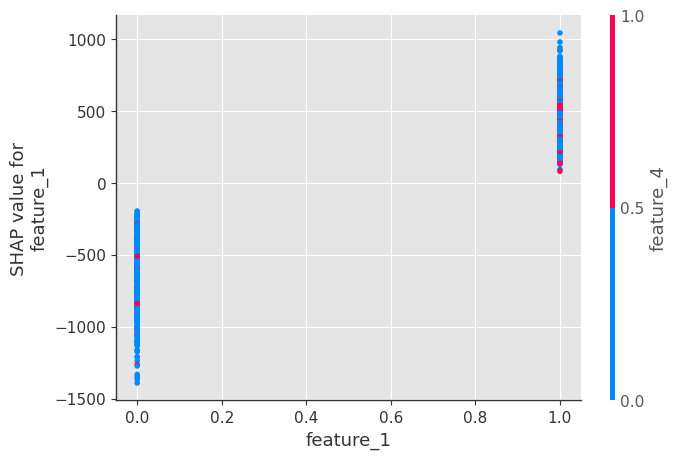

In [18]:
feature_names = X_train.columns.tolist()

# Seleccionar las variables que te interesan (puedes usar los nombres directamente)
variable1_name = 'feature_1'
variable2_name = 'feature_4'

# Encontrar los índices correspondientes a los nombres de las variables
variable1_index = feature_names.index(variable1_name)
variable2_index = feature_names.index(variable2_name)

# Crear un Dependence Plot
shap.dependence_plot(variable1_index, shap_values, X_train, feature_names=feature_names, interaction_index=variable2_index, show=False)
plt.show()

# NOTAS

- Los colores generan overfitting... correlacion no implica causalidad